# 3. Etapa de entrenamiento y testeo de un modelo de análisis de sentimiento

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# Asegurar instalación de spaCy y su modelo antes de importar nada
!pip install -q spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 60.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [41]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/PracticaNLP")  # Añadir ruta para importar features.py

import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib

from features import extract_sentiment_features  # ✅ importación desde archivo .py

# Paso 1: cargar dataset procesado
json_path = "/content/drive/MyDrive/Colab Notebooks/PracticaNLP/data/clean_reviews.json"
df = extract_sentiment_features(json_path)
print(df.head())

                                          clean_text  review_length  \
0  adorable romper ! belt zipper little hard navi...            221   
1  rent dress photo shoot theme hollywood glam bi...            221   
2  hug right place ! perfect dress event receive ...            198   
3  rent company black tie award banquet like dres...            465   
4  petite upper body extremely athletic typically...            559   

   num_tokens  num_sentences  num_nouns  num_verbs  num_adjectives  \
0          48              4         10          5               6   
1          47              4          7          3               4   
2          42              3          7          4               5   
3         105              9         16         10              12   
4         126              9         19         13              12   

   num_adverbs  has_exclamation  has_question  rating  
0            1                1             0       1  
1            4                0         

Pues parece ser que si que hay palabras en otro idioma que no es inglés, como romper, aunque no descarto que sean simples errores del traductor del móvil de ese usuario o lo que sea, vamos, una gran minoría, con un grafico de barras y detectando palabras por idioma, quizás vea su frecuencia, esta investigación más en profundidad lo dejaré para líneas futuras, porque es muy especifico y creo que no rompe casi el código para el tiempo que requeriría.

In [42]:
# Paso 2: separar X e y
X_text = df["clean_text"]
y = df["rating"]

# Paso 3: dividir en entrenamiento y test
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

🎯 Distribución en y_train:
rating
1    3516
0      83
Name: count, dtype: int64

🎯 Distribución en y_test:
rating
1    879
0     21
Name: count, dtype: int64


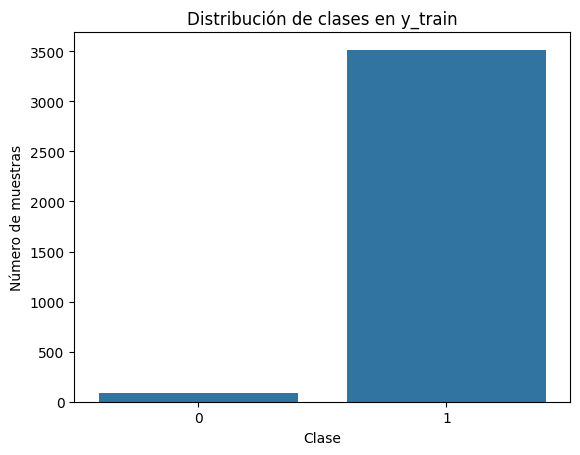

In [43]:
# Paso 4: Ver distribución de clases para la varible objetivo (lo que nos interesa predecir)
import seaborn as sns
import matplotlib.pyplot as plt

# Recuento de clases en train y test
print("🎯 Distribución en y_train:")
print(y_train.value_counts())

print("\n🎯 Distribución en y_test:")
print(y_test.value_counts())

# Visualizar con gráfico
sns.countplot(x=y_train)
plt.title("Distribución de clases en y_train")
plt.xlabel("Clase")
plt.ylabel("Número de muestras")
plt.show()

# a. Modelos de Machine Learning

In [44]:
# Paso 5: vectorizar texto limpio partido / token (paso el texto a números que los modelos puedan y sepan interpretar)
tfidf = TfidfVectorizer(max_features=1000,   # max_features=1000 => elige las 1000 palabras más comunes y reduce la dimensionalidad del modelo → menos sobreajuste, más rápido
                        ngram_range=(1, 2))  # ngram_range=(1, 2) => capturo unigramas ("Camisa") y bigramas ("Ralph Lauren")
X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

In [45]:
# Paso 6: Ver visualmente lo comentado en el paso 4
X_train_array = X_train.toarray()  # Convertir a array (correctamente) # ✅ AQUÍ es donde va .toarray()
X_train_df = pd.DataFrame(X_train_array, columns=tfidf.get_feature_names_out()) # Crear DataFrame con nombres de columnas (tokens)
print(X_train_df.head()) # Ver primeras filas para confirmar que no hay texto, solo números

   able  able dance  able wear  absolutely  absolutely love  accentuate  \
0   0.0         0.0        0.0         0.0              0.0         0.0   
1   0.0         0.0        0.0         0.0              0.0         0.0   
2   0.0         0.0        0.0         0.0              0.0         0.0   
3   0.0         0.0        0.0         0.0              0.0         0.0   
4   0.0         0.0        0.0         0.0              0.0         0.0   

   accessory  accommodate  actually  add  ...  worry  worth  wow  wrap  \
0        0.0          0.0       0.0  0.0  ...    0.0    0.0  0.0   0.0   
1        0.0          0.0       0.0  0.0  ...    0.0    0.0  0.0   0.0   
2        0.0          0.0       0.0  0.0  ...    0.0    0.0  0.0   0.0   
3        0.0          0.0       0.0  0.0  ...    0.0    0.0  0.0   0.0   
4        0.0          0.0       0.0  0.0  ...    0.0    0.0  0.0   0.0   

   wrinkle  wrong   xs  year  zip  zipper  
0      0.0    0.0  0.0   0.0  0.0     0.0  
1      0.0    0.

In [46]:
# Paso 7: entrenar modelos balanceados (los tengo que balancear porque las clases están claramente muy desbalanceadas como se vió en Ejercicio1.ipybn)
# Tengo que balancear pesos sí o sí, porque es que si no solo entreno con un clase prácticamente
log_model = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
log_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Paso 6: guardar modelos y vectorizador para el Ejercicio 4
os.makedirs("/content/drive/MyDrive/Colab Notebooks/PracticaNLP/models", exist_ok=True)

joblib.dump(log_model, "/content/drive/MyDrive/Colab Notebooks/PracticaNLP/models/logistic_model.joblib")
joblib.dump(rf_model, "/content/drive/MyDrive/Colab Notebooks/PracticaNLP/models/rf_model.joblib")
joblib.dump(tfidf, "/content/drive/MyDrive/Colab Notebooks/PracticaNLP/models/tfidf.joblib")
joblib.dump((X_train, y_train), "/content/drive/MyDrive/Colab Notebooks/PracticaNLP/models/train_data.joblib")
joblib.dump((X_test, y_test), "/content/drive/MyDrive/Colab Notebooks/PracticaNLP/models/test_data.joblib")

print("✅ Modelos ML y datos de test guardados correctamente.")

✅ Modelos ML y datos de test guardados correctamente.


# b. Modelo de Deep Learning (RNN)

In [47]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os
import joblib

# Tokenización para LSTM (TfidfVectorizer o CountVectorizer no sirve para DeepLearning, y la verdad es que Word2Vec o Glove me cansa un poco hacerlo para esto, prefiero algo más rápido ahora mismo)
tokenizer = Tokenizer(oov_token="<OOV>") # si la palabra encontrada no está en el vocabulario, se sustituye por "<OOV>"
tokenizer.fit_on_texts(X_train_text) # aprende sobre el texto y crear un diccionario clave valor
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)  # Sustituye cada palabra/clave por su valor numérico/valor (del diccionario)
print(X_train_seq[0])

[2, 1266, 235, 930, 931, 235, 12, 15, 87, 204, 29, 6, 13, 2]


In [48]:
# Calcular longitud media para padding razonable
avg_len = int(np.mean([len(seq) for seq in X_train_seq]))
maxlen = min(avg_len, 100)  # limitar para no alargar si hay ruido

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post') # Rellenas, por defecto al principio con padding='pre', pero yo lo quiero al final con 'post'
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')
print(X_train_pad[0])

[   2 1266  235  930  931  235   12   15   87  204   29    6   13    2
    0    0    0    0    0    0    0    0    0    0]


En Embedding solo declara:

*    Cuántas palabras puede manejar (input_dim).

*    Qué tamaño tendrán los vectores (output_dim).

No es hasta que alimento datos al modelo (por ejemplo, model.predict(X_train_pad)) cuando:

*   Los índices reales (de X_train_pad) entran en acción.

*   La capa Embedding convierte cada índice en su vector correspondiente.


In [49]:
# Crear modelo LSTM
vocab_size = len(tokenizer.word_index) + 1
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64),  # convertir Índices → vectores densos
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                                                                           tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.F1Score(name='f1_score')])

# Entrenamiento con early stopping
# Con restore_best_weights=False me quedo con los pesos finales (aunque haya empeorado el entrenamiento)
# patiente=2 , si no mejora la pérdida de validación durante 2 épocas seguidas, se detiene el entrenamiento.
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Guardar modelo LSTM y tokenizer
os.makedirs("/content/drive/MyDrive/Colab Notebooks/PracticaNLP/models", exist_ok=True)
lstm_model.save("/content/drive/MyDrive/Colab Notebooks/PracticaNLP/models/lstm_model.keras")
joblib.dump(tokenizer, "/content/drive/MyDrive/Colab Notebooks/PracticaNLP/models/tokenizer_lstm.joblib")
joblib.dump((X_test_pad, y_test), "/content/drive/MyDrive/Colab Notebooks/PracticaNLP/models/test_data_lstm.joblib")

print("✅ Modelo LSTM y tokenizer guardados correctamente.")

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.9546 - f1_score: 0.9894 - loss: 0.2940 - precision: 0.9823 - recall: 0.9712 - val_accuracy: 0.9764 - val_f1_score: 0.9881 - val_loss: 0.1116 - val_precision: 0.9764 - val_recall: 1.0000
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9763 - f1_score: 0.9880 - loss: 0.1120 - precision: 0.9763 - recall: 1.0000 - val_accuracy: 0.9764 - val_f1_score: 0.9881 - val_loss: 0.1113 - val_precision: 0.9764 - val_recall: 1.0000
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9791 - f1_score: 0.9894 - loss: 0.1024 - precision: 0.9791 - recall: 1.0000 - val_accuracy: 0.9764 - val_f1_score: 0.9881 - val_loss: 0.1123 - val_precision: 0.9764 - val_recall: 1.0000
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9809 - f1_score: 0.9904 - loss: 0.0946 - precision: 0.9809 - recall: 1.0000 - val_accuracy: 0.9764 - val_f1_score: 0.9881 - val_loss: 0.1115 - val_precision: 0.9764 - val_recall: 1.